In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import random
from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

# For reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device in use: cuda


In [3]:
# CIFAR‑10 normalization values (mean, std per channel)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

train_data = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_data = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

val_size = 5000
train_size = len(train_data) - val_size
train_ds, val_ds = random_split(train_data, [train_size, val_size])

batch_size = 64

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=batch_size*2)
test_dl  = DataLoader(test_data, batch_size=batch_size*2)

print(f"Data sizes: {len(train_ds)} train / {len(val_ds)} val / {len(test_data)} test")

Data sizes: 45000 train / 5000 val / 10000 test


In [4]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [5]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out)


class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(channels, reduction)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x

In [6]:
class LeNetCIFAR_Attn(nn.Module):
    def __init__(self, attention=None, position="none"):
        super().__init__()
        self.position = position
        self.attention = attention

        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # "All" attention → create one per stage
        if position == "all" and attention is not None:
            attn_class = attention.__class__
            self.attn1 = attn_class(32)
            self.attn2 = attn_class(64)
            self.attn3 = attn_class(128)
        else:
            self.attn1 = self.attn2 = self.attn3 = None

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        if self.position in ["early"] and self.attention:
            x = self.attention(x)
        if self.position == "all" and self.attn1:
            x = self.attn1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        if self.position in ["mid"] and self.attention:
            x = self.attention(x)
        if self.position == "all" and self.attn2:
            x = self.attn2(x)

        x = self.pool3(F.relu(self.conv3(x)))
        if self.position in ["late"] and self.attention:
            x = self.attention(x)
        if self.position == "all" and self.attn3:
            x = self.attn3(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
class SmallAlexNet_Attn(nn.Module):
    def __init__(self, attention=None, position="none"):
        super().__init__()
        self.position = position
        self.attention = attention

        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv4 = nn.Sequential(nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2))

        if position == "all" and attention is not None:
            cls = attention.__class__
            self.attn1 = cls(64)
            self.attn2 = cls(128)
            self.attn3 = cls(256)
            self.attn4 = cls(512)
        else:
            self.attn1 = self.attn2 = self.attn3 = self.attn4 = None

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        if self.position == "early" and self.attention:
            x = self.attention(x)
        if self.position == "all" and self.attn1:
            x = self.attn1(x)

        x = self.conv2(x)
        if self.position == "mid1" and self.attention:
            x = self.attention(x)
        if self.position == "all" and self.attn2:
            x = self.attn2(x)

        x = self.conv3(x)
        if self.position == "mid2" and self.attention:
            x = self.attention(x)
        if self.position == "all" and self.attn3:
            x = self.attn3(x)

        x = self.conv4(x)
        if self.position == "late" and self.attention:
            x = self.attention(x)
        if self.position == "all" and self.attn4:
            x = self.attn4(x)

        return self.classifier(x)

In [8]:
class BasicBlock_Attn(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None, attention=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.attention = attention

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.attention:
            out = self.attention(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.relu(out + identity)
        return out


class ResNet_Attn(nn.Module):
    def __init__(self, block, layers, attention_type=None, position="none", num_classes=10):
        super().__init__()
        self.in_planes = 64
        self.attention_type = attention_type
        self.position = position

        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, layers[0], layer_name="early")
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, layer_name="mid1")
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, layer_name="mid2")
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, layer_name="late")

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride=1, layer_name="none"):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        for i in range(num_blocks):
            attn = None
            if self.attention_type and self.position in [layer_name, "all"]:
                attn = SEBlock(planes) if self.attention_type == "SE" else CBAM(planes, kernel_size=3)
            layers.append(
                block(self.in_planes, planes, stride if i == 0 else 1,
                      downsample if i == 0 else None, attention=attn)
            )
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


def ResNet18_Attn(attention_type=None, position="none"):
    return ResNet_Attn(BasicBlock_Attn, [2, 2, 2, 2], attention_type, position)

In [9]:
from torchsummary import summary

model_lenet = LeNetCIFAR_Attn().to(device)
summary(model_lenet, input_size=(3, 32, 32))

model_alex = SmallAlexNet_Attn().to(device)
summary(model_alex, input_size=(3, 32, 32))

model_res = ResNet18_Attn().to(device)
summary(model_res, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          51,264
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
         MaxPool2d-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 256]         524,544
            Linear-8                  [-1, 128]          32,896
            Linear-9                   [-1, 10]           1,290
Total params: 686,282
Trainable params: 686,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 2.62
Estimated Total Size (MB): 3.18
-------------------------------------------

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return (preds == labels).float().mean().item()


@torch.no_grad()
def evaluate(model, dl, criterion):
    model.eval()
    losses, accs = [], []
    for images, labels in dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        accs.append(accuracy(outputs, labels))
    return np.mean(losses), np.mean(accs)

In [11]:
def fit(model, train_dl, val_dl, epochs=20, lr=0.01, patience=5, min_delta=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

    best = float("inf")
    no_improve = 0
    history = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        scheduler.step()
        val_loss, val_acc = evaluate(model, val_dl, criterion)
        train_loss /= len(train_dl)

        history.append({"epoch": epoch + 1,
                        "train_loss": train_loss,
                        "val_loss": val_loss,
                        "val_acc": val_acc})

        print(f"Epoch [{epoch+1}/{epochs}] | Train {train_loss:.3f} | Val {val_loss:.3f} | ValAcc {val_acc:.3f}")

        if best - val_loss > min_delta:
            best = val_loss
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stop at epoch", epoch + 1)
            break

    return history

In [12]:
def train_and_record(model_name, model, attn, pos):
    model = model.to(device)
    start = time.time()

    # --- Training ---
    hist = fit(model, train_dl, val_dl)

    end = time.time()
    total_seconds = end - start
    duration_min = total_seconds / 60
    avg_epoch_time = total_seconds / len(hist)

    # Approx throughput (only rough estimate)
    total_images = len(train_dl.dataset)
    images_per_sec = total_images * len(hist) / total_seconds

    # --- Evaluation ---
    best_acc = max(h["val_acc"] for h in hist)
    best_loss = min(h["val_loss"] for h in hist)
    test_loss, test_acc = evaluate(model, test_dl, nn.CrossEntropyLoss())

    return {
        "model": model_name,
        "attention": attn,
        "position": pos,
        "best_val_acc": best_acc,
        "best_val_loss": best_loss,
        "test_acc": test_acc,
        "train_time_min": duration_min,
        "avg_epoch_s": avg_epoch_time,
        "images_per_sec": images_per_sec,
        "history": hist,
    }

In [13]:
attn_types = {"None": None, "SE": SEBlock, "CBAM": CBAM}
results = []

positions_lenet = ["early", "mid", "late", "all"]
positions_alex = ["early", "mid1", "mid2", "late", "all"]
positions_res = ["early", "mid1", "mid2", "late", "all"]

# ---- LeNet ----
for attn_name, block in attn_types.items():
    if attn_name == "None":
        print("\n[LeNet baseline]")
        model = LeNetCIFAR_Attn().to(device)
        results.append(train_and_record("LeNet", model, "None", "none"))
    else:
        for pos in positions_lenet:
            ch = 32 if pos == "early" else 64 if pos == "mid" else 128
            model = LeNetCIFAR_Attn(attention=block(ch), position=pos)
            print(f"\n[LeNet + {attn_name} at {pos}]")
            results.append(train_and_record("LeNet", model, attn_name, pos))

# ---- AlexNet ----
for attn_name, block in attn_types.items():
    if attn_name == "None":
        print("\n[AlexNet baseline]")
        model = SmallAlexNet_Attn().to(device)
        results.append(train_and_record("AlexNet", model, "None", "none"))
    else:
        for pos in positions_alex:
            ch = 64 if pos == "early" else 128 if pos == "mid1" else 256 if pos == "mid2" else 512
            model = SmallAlexNet_Attn(attention=block(ch), position=pos)
            print(f"\n[AlexNet + {attn_name} at {pos}]")
            results.append(train_and_record("AlexNet", model, attn_name, pos))

# ---- ResNet18 ----
for attn_name in attn_types.keys():
    if attn_name == "None":
        print("\n[ResNet18 baseline]")
        model = ResNet18_Attn().to(device)
        results.append(train_and_record("ResNet18", model, "None", "none"))
    else:
        for pos in positions_res:
            print(f"\n[ResNet18 + {attn_name} at {pos}]")
            model = ResNet18_Attn(attention_type=attn_name, position=pos)
            results.append(train_and_record("ResNet18", model, attn_name, pos))


[LeNet baseline]
Epoch [1/20] | Train 1.676 | Val 1.390 | ValAcc 0.498
Epoch [2/20] | Train 1.128 | Val 0.978 | ValAcc 0.657
Epoch [3/20] | Train 0.885 | Val 0.883 | ValAcc 0.693
Epoch [4/20] | Train 0.730 | Val 0.817 | ValAcc 0.715
Epoch [5/20] | Train 0.609 | Val 0.783 | ValAcc 0.738
Epoch [6/20] | Train 0.503 | Val 0.798 | ValAcc 0.735
Epoch [7/20] | Train 0.258 | Val 0.684 | ValAcc 0.783
Epoch [8/20] | Train 0.189 | Val 0.702 | ValAcc 0.786
Epoch [9/20] | Train 0.153 | Val 0.739 | ValAcc 0.786
Epoch [10/20] | Train 0.124 | Val 0.787 | ValAcc 0.791
Epoch [11/20] | Train 0.099 | Val 0.825 | ValAcc 0.788
Epoch [12/20] | Train 0.078 | Val 0.879 | ValAcc 0.786
Early stop at epoch 12

[LeNet + SE at early]
Epoch [1/20] | Train 1.823 | Val 1.446 | ValAcc 0.464
Epoch [2/20] | Train 1.253 | Val 1.099 | ValAcc 0.610
Epoch [3/20] | Train 0.999 | Val 0.950 | ValAcc 0.661
Epoch [4/20] | Train 0.816 | Val 0.892 | ValAcc 0.686
Epoch [5/20] | Train 0.687 | Val 0.855 | ValAcc 0.710
Epoch [6/20] | 

,model,attention,position,best_val_acc,best_val_loss,test_acc,train_time_min,avg_epoch_s,images_per_sec
0,ResNet18,CBAM,late,0.866797,0.438014,0.853046,3.650277,18.251387,2465.565996
1,ResNet18,SE,late,0.860156,0.472246,0.845530,3.538319,17.691593,2543.580963
2,ResNet18,CBAM,early,0.857812,0.495236,0.840783,3.789582,18.947911,2374.932021
3,ResNet18,SE,early,0.856641,0.500903,0.843453,3.593633,17.968167,2504.429132
4,ResNet18,None,none,0.855469,0.482453,0.846321,3.456032,17.280162,2604.142223
5,ResNet18,SE,mid1,0.855273,0.487794,0.847310,3.546220,17.731099,2537.913686
6,ResNet18,SE,mid2,0.854492,0.487558,0.850079,3.529513,17.647563,2549.927108
7,ResNet18,CBAM,mid2,0.854297,0.501881,0.840487,3.626215,18.131076,2481.926605
8,ResNet18,CBAM,mid1,0.854102,0.506865,0.844244,3.655804,18.279019,2461.838920
9,ResNet18,SE,all,0.852344,0.488258,0.837619,3.811398,19.056988,2361.338501


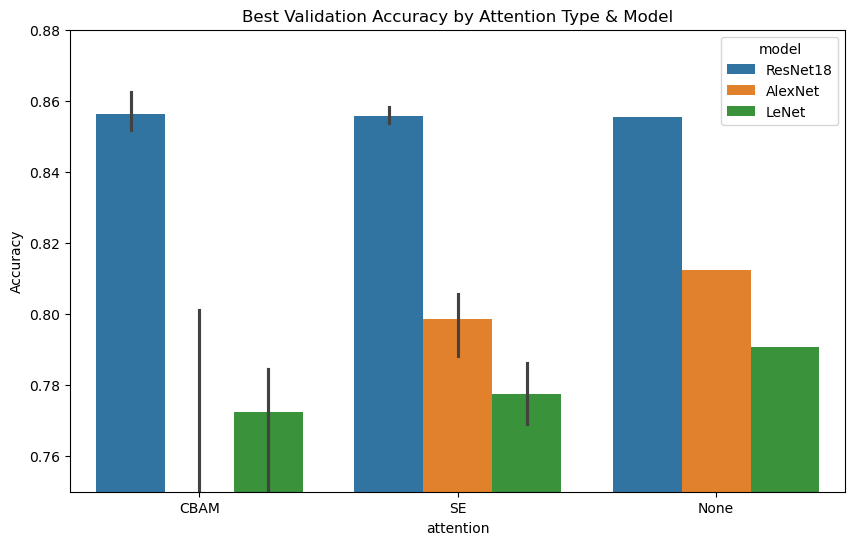

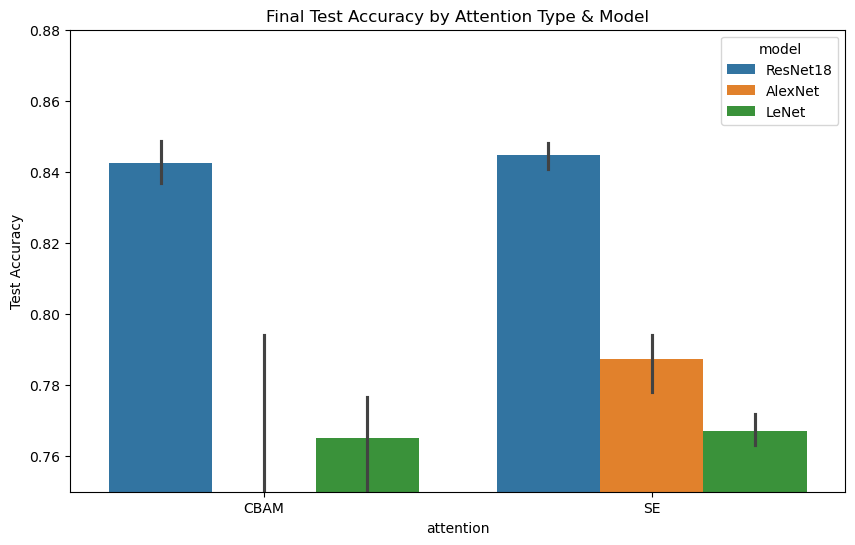

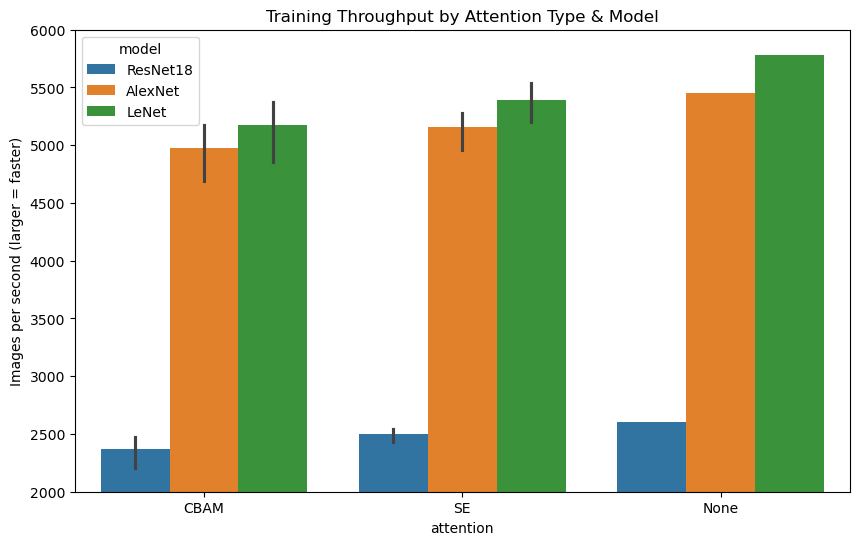

In [23]:
df = pd.DataFrame([{k: v for k, v in r.items() if k != "history"} for r in results])
df = df.sort_values("best_val_acc", ascending=False).reset_index(drop=True)
df.to_csv("attention_results_lenet_alex_resnet.csv", index=False)
display(df)

plt.figure(figsize=(10, 6))
sns.barplot(df, x="attention", y="best_val_acc", hue="model")
plt.title("Best Validation Accuracy by Attention Type & Model")
plt.ylabel("Accuracy")
plt.ylim(0.75, 0.88)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(df[df["attention"] != "None"], x="attention", y="test_acc", hue="model")
plt.title("Final Test Accuracy by Attention Type & Model")
plt.ylabel("Test Accuracy")
plt.ylim(0.75, 0.88)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(df, x="attention", y="images_per_sec", hue="model")
plt.title("Training Throughput by Attention Type & Model")
plt.ylabel("Images per second (larger = faster)")
plt.ylim(2000, 6000)
plt.show()

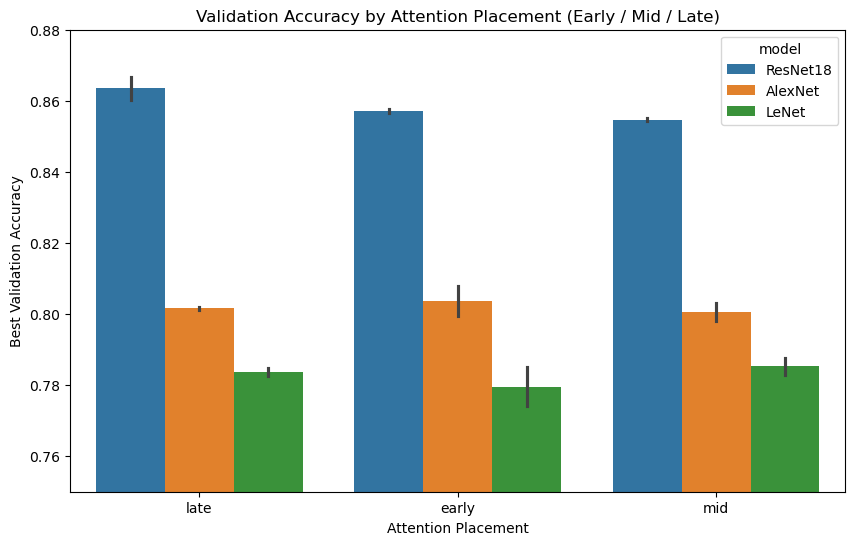

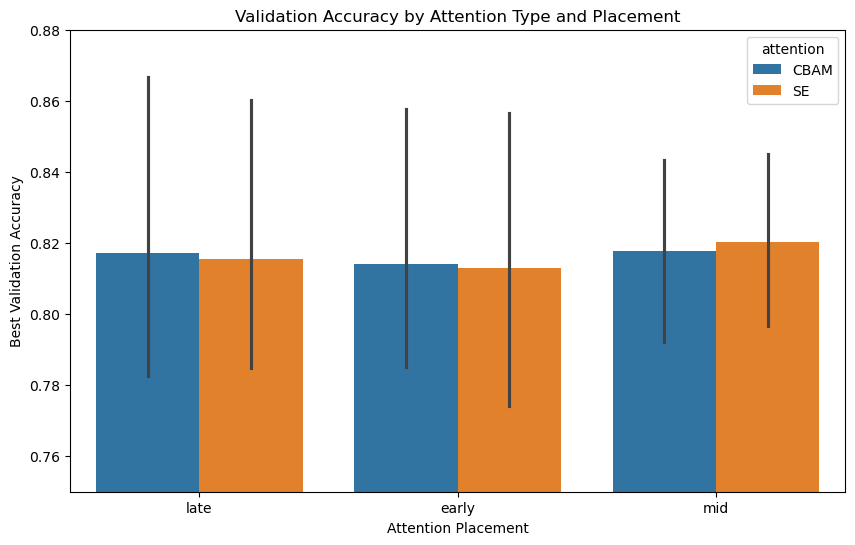

In [20]:
# --- Accuracy Comparison by Attention Placement (Early / Mid / Late) ---

# Create a filtered dataframe including relevant positions
positions_to_plot = ["early", "mid", "mid1", "mid2", "late"]
df_pos = df[df["position"].isin(positions_to_plot) & (df["attention"] != "None")].copy()

# Merge mid1 and mid2 into a single "mid"
df_pos["position_category"] = df_pos["position"].replace({"mid1": "mid", "mid2": "mid"})

plt.figure(figsize=(10, 6))
sns.barplot(df_pos, x="position_category", y="best_val_acc", hue="model")
plt.title("Validation Accuracy by Attention Placement (Early / Mid / Late)")
plt.ylabel("Best Validation Accuracy")
plt.xlabel("Attention Placement")
plt.ylim(0.75, 0.88)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(df_pos, x="position_category", y="best_val_acc", hue="attention")
plt.title("Validation Accuracy by Attention Type and Placement")
plt.ylabel("Best Validation Accuracy")
plt.xlabel("Attention Placement")
plt.ylim(0.75, 0.88)
plt.show()

In [16]:
def plot_training_curves(history, title="Training"):
    epochs = [h["epoch"] for h in history]
    tl = [h["train_loss"] for h in history]
    vl = [h["val_loss"] for h in history]
    va = [h["val_acc"] for h in history]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tl, "-bx", label="Train loss")
    plt.plot(epochs, vl, "-rx", label="Val loss")
    plt.legend(); plt.title(f"Loss — {title}")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, va, "-gx", label="Val acc")
    plt.legend(); plt.title(f"Accuracy — {title}")
    plt.show()

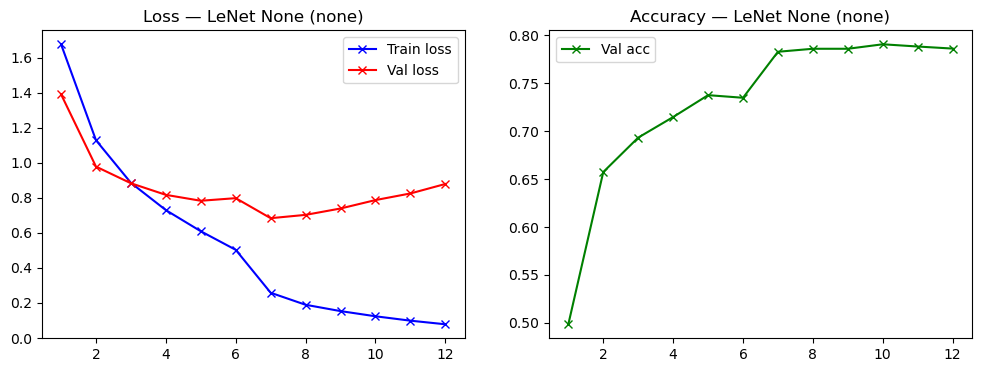

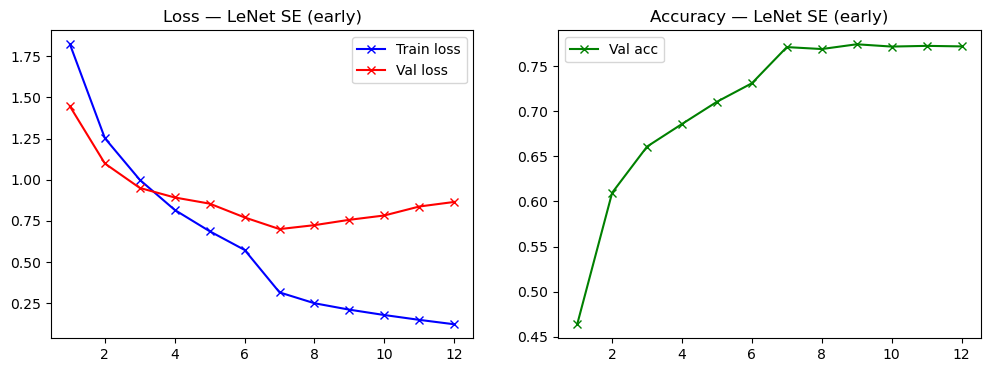

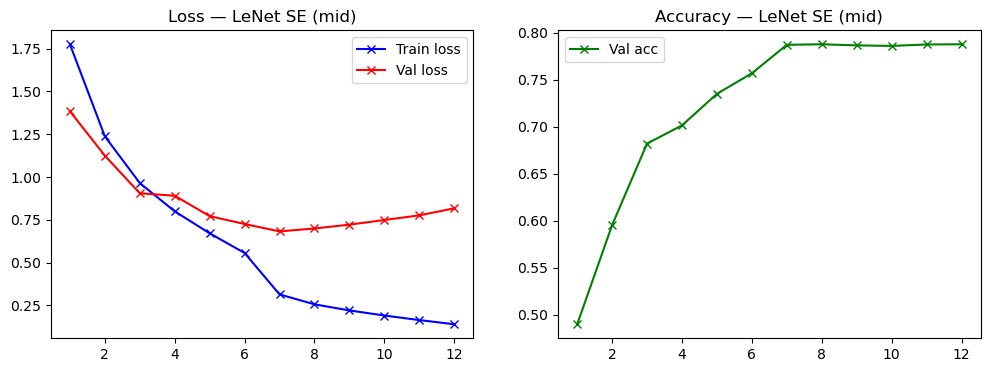

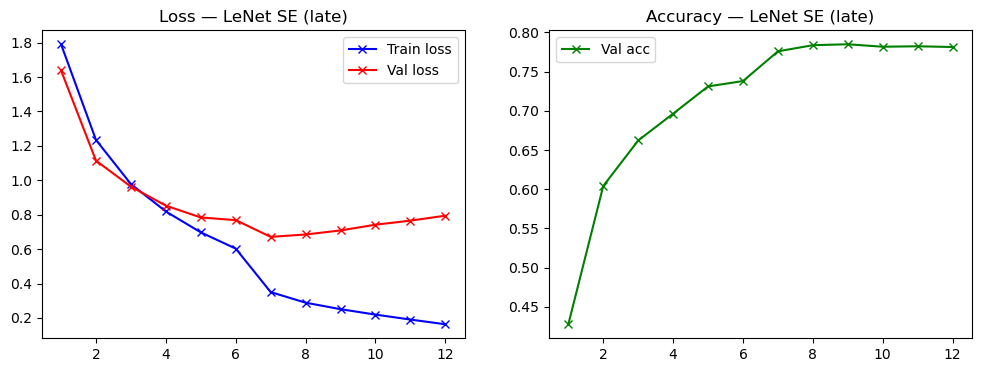

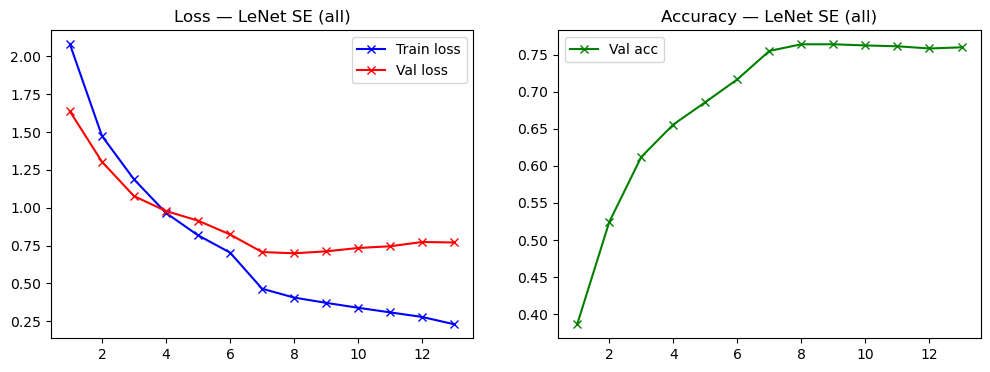

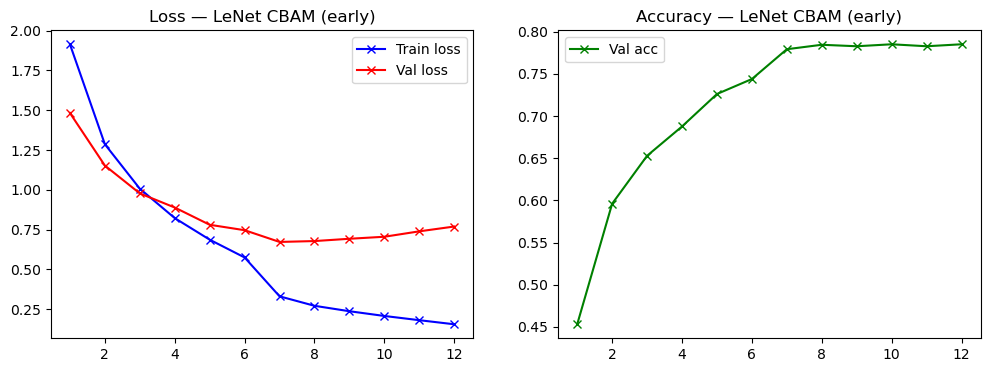

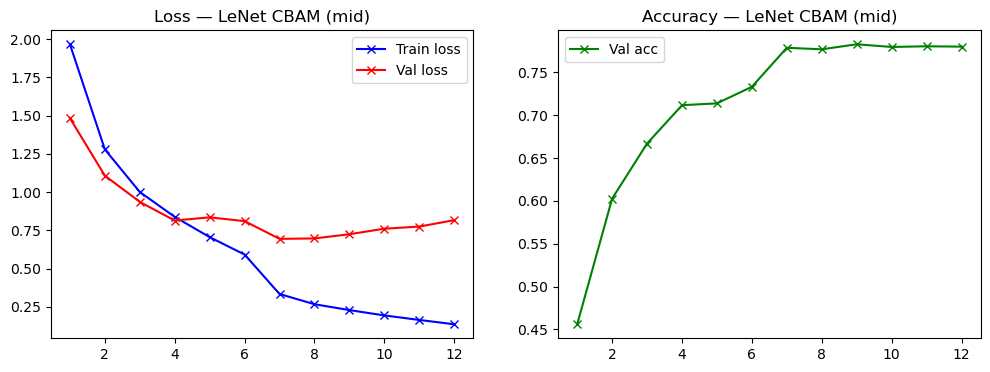

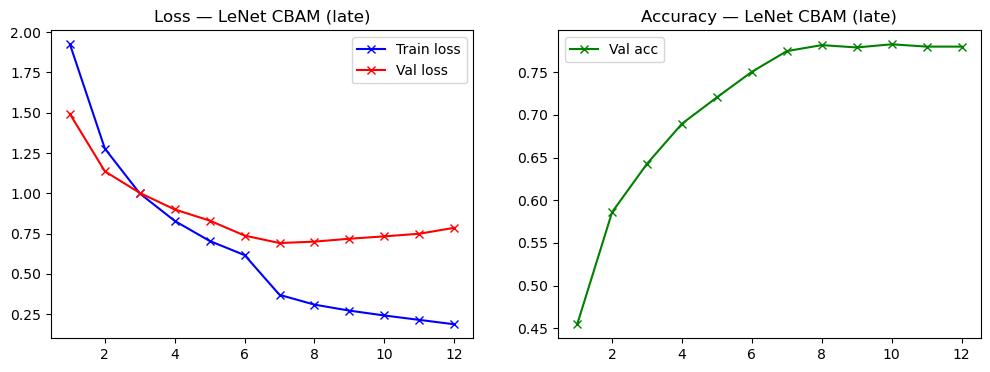

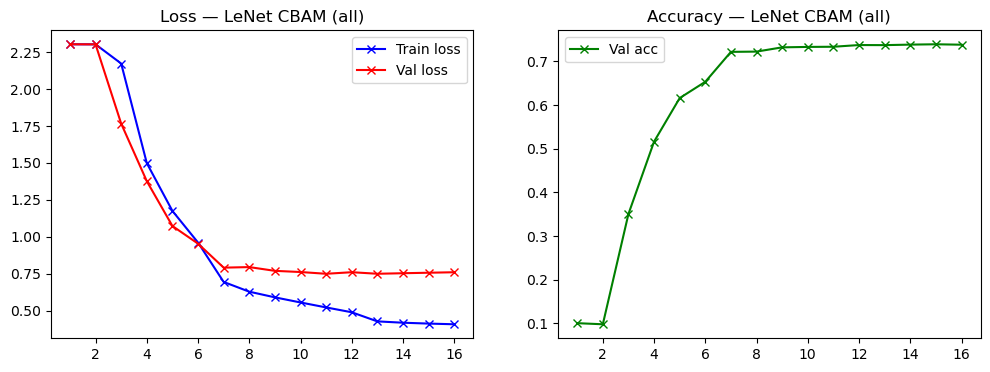

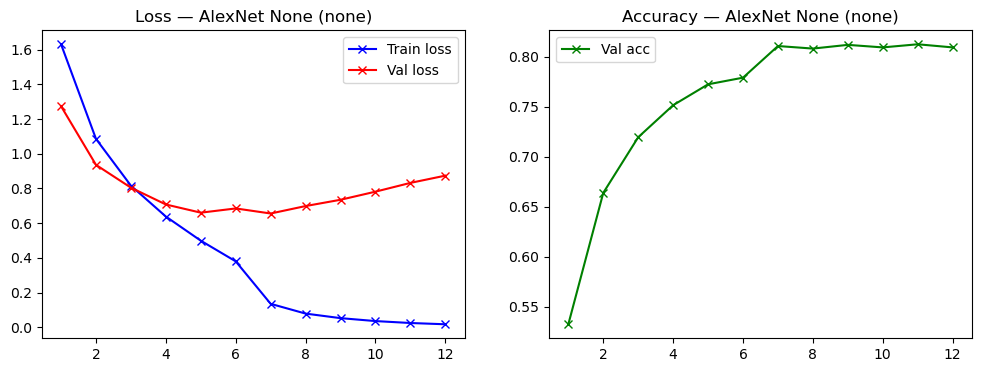

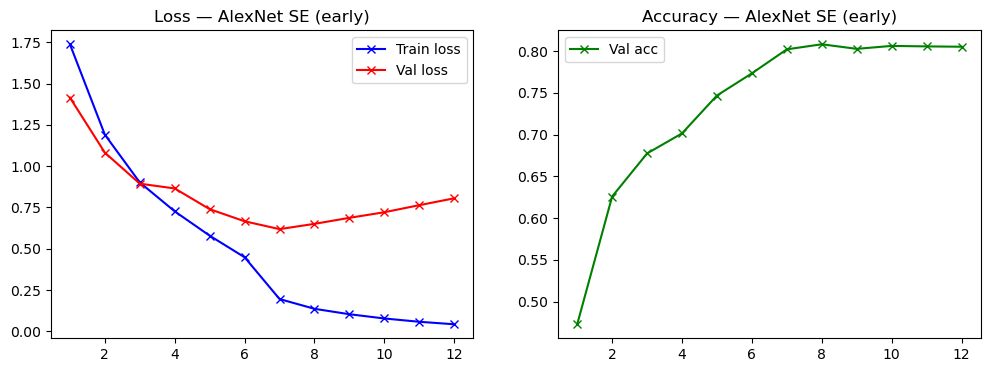

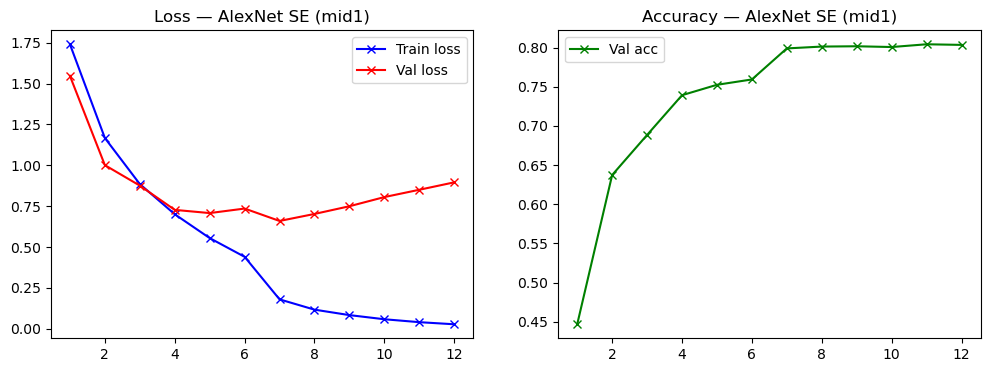

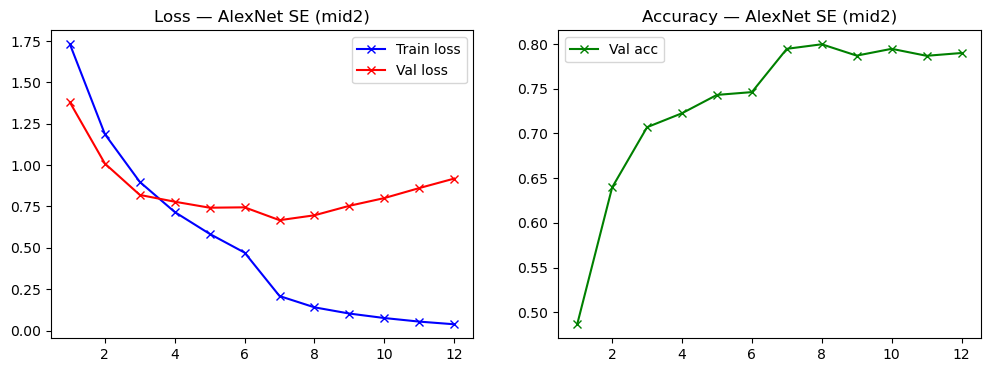

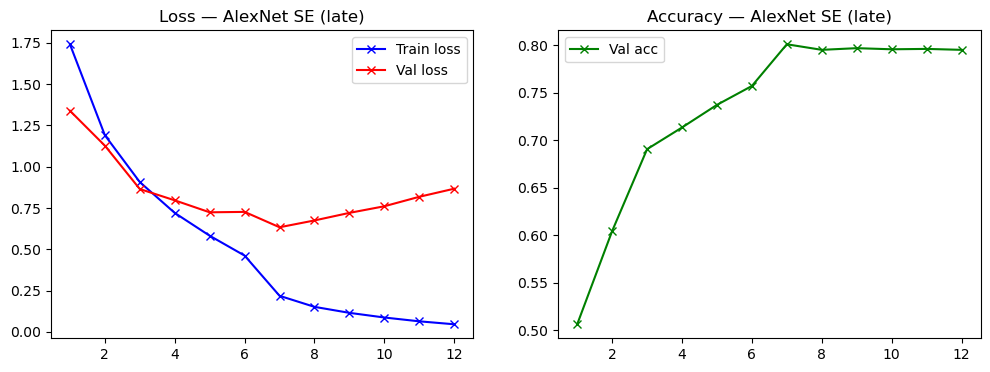

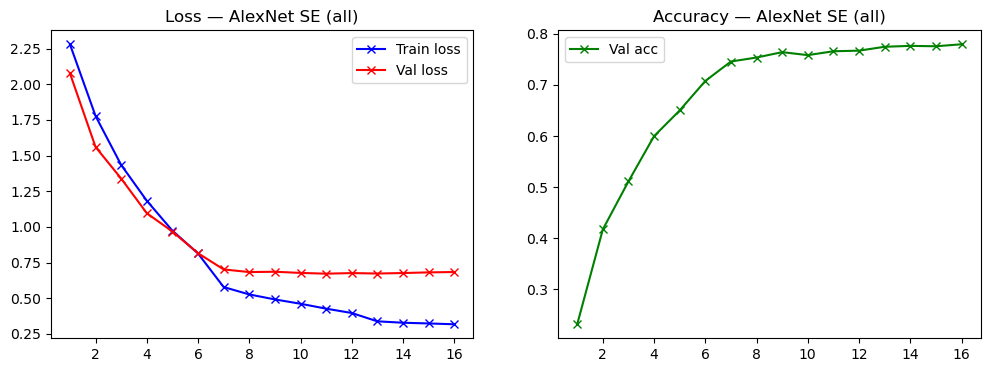

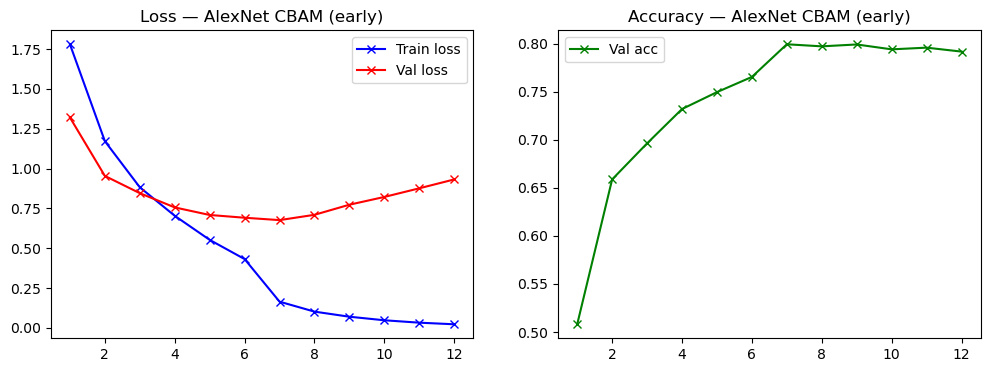

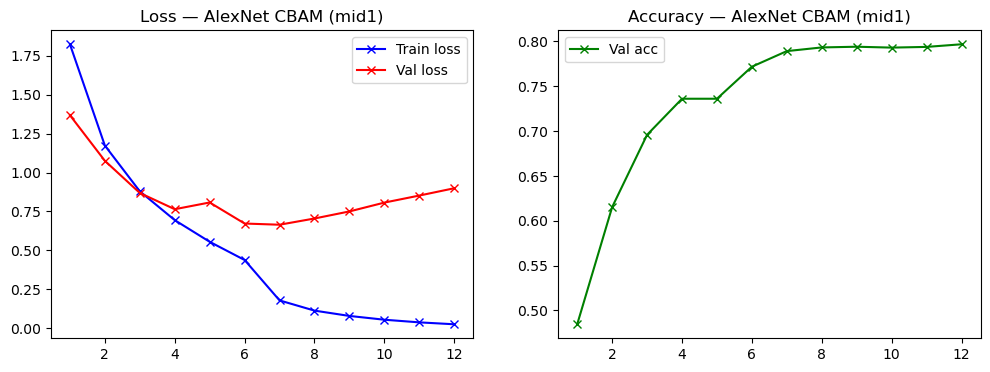

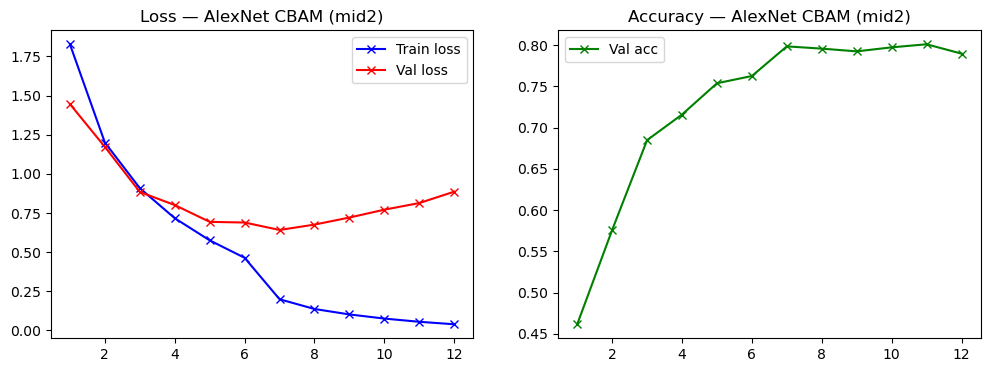

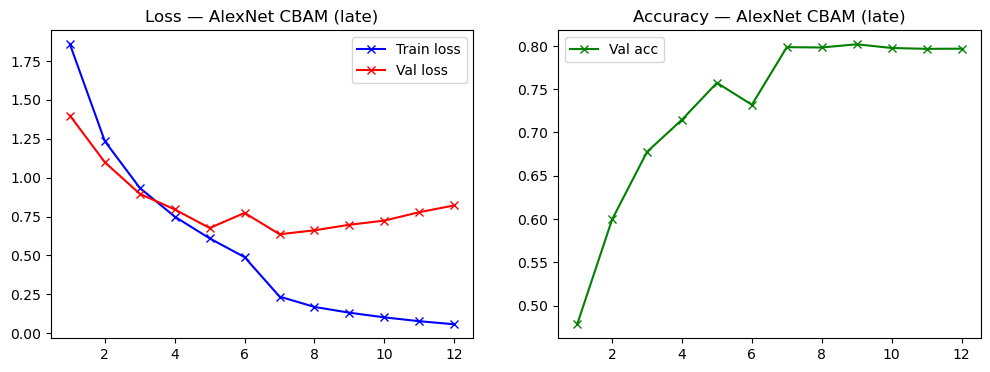

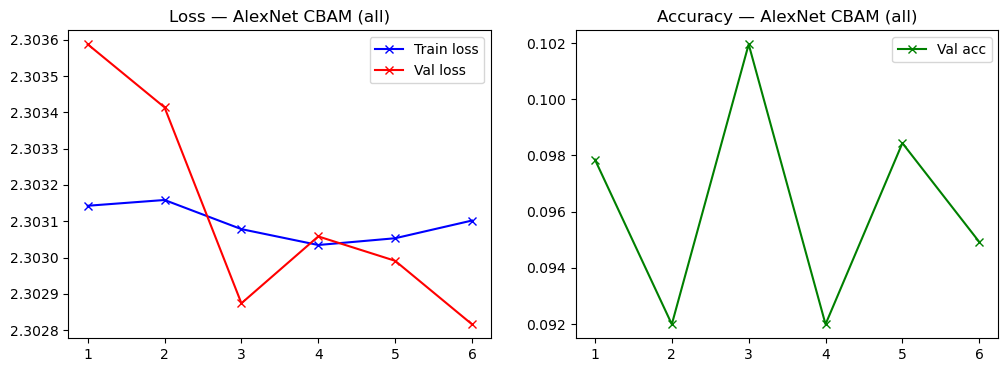

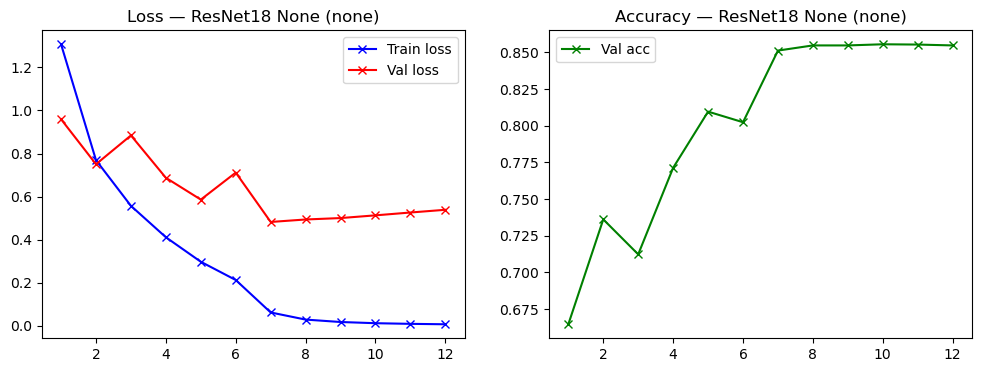

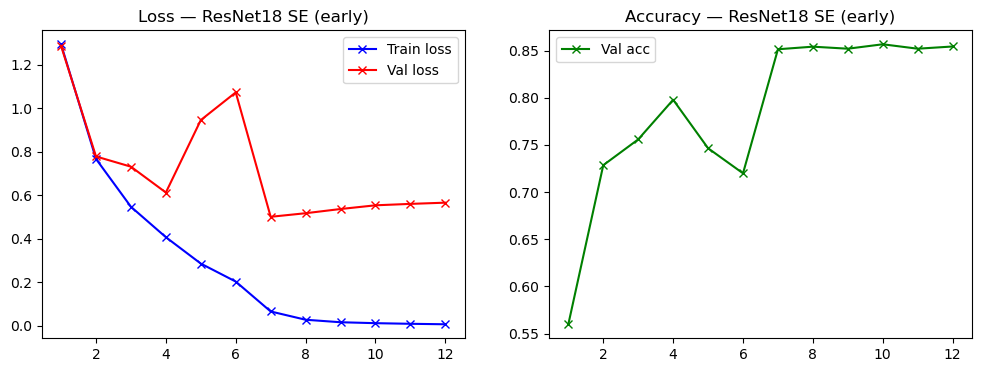

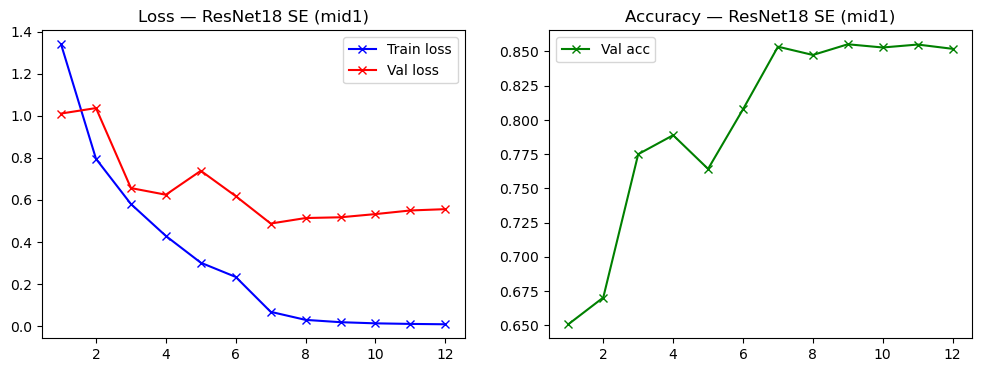

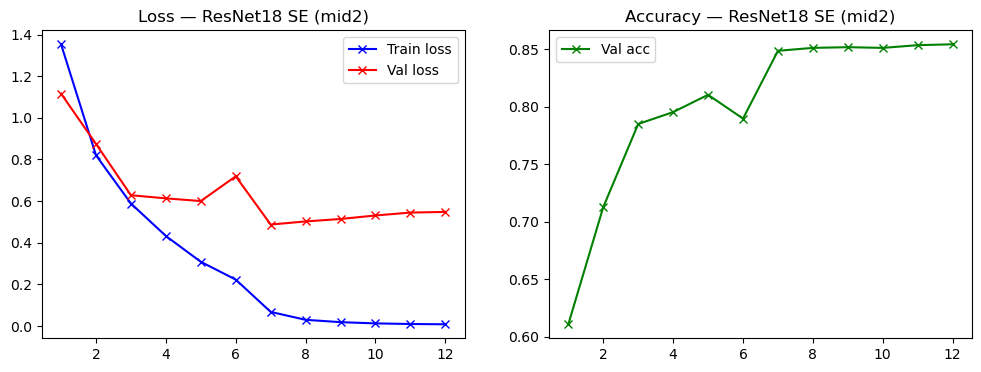

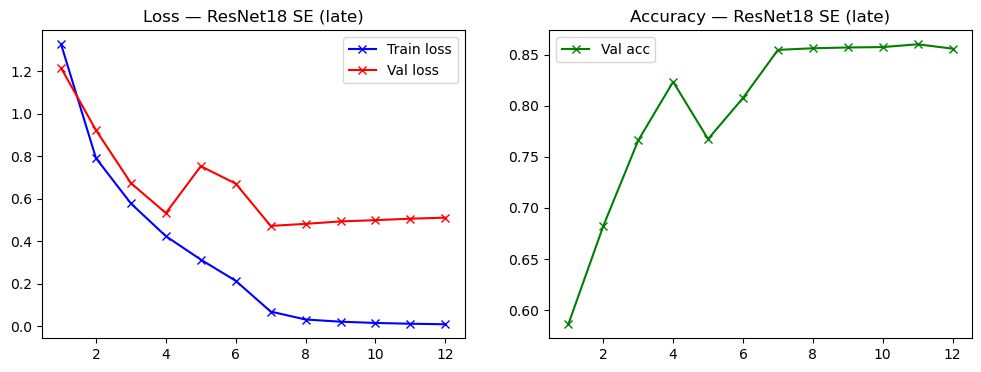

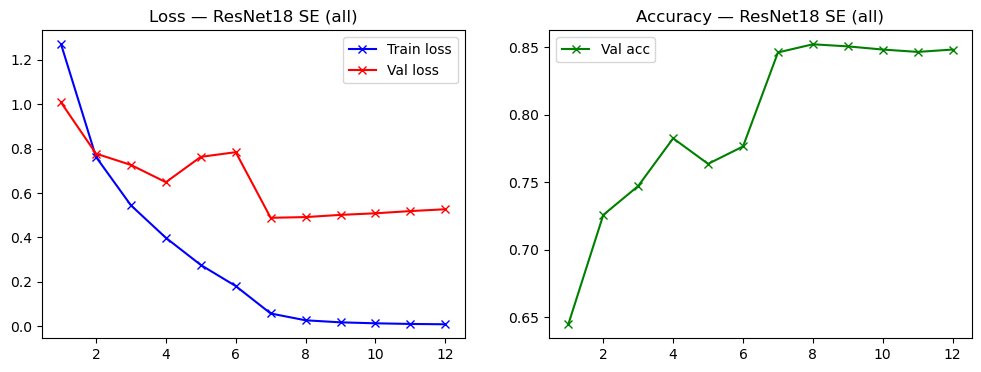

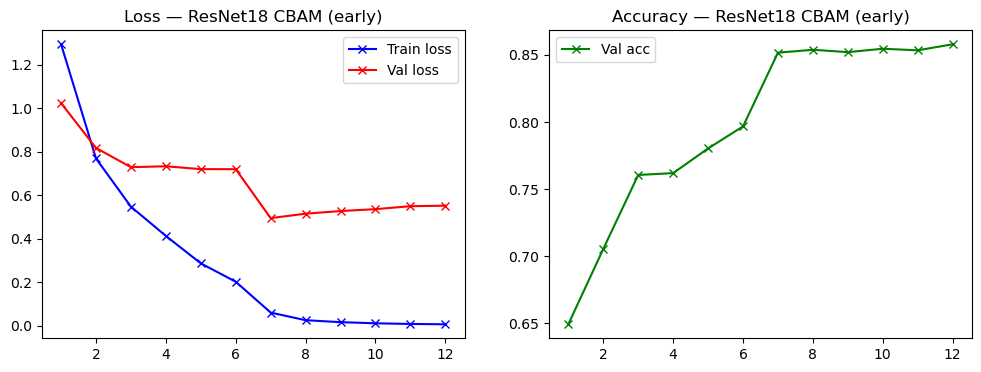

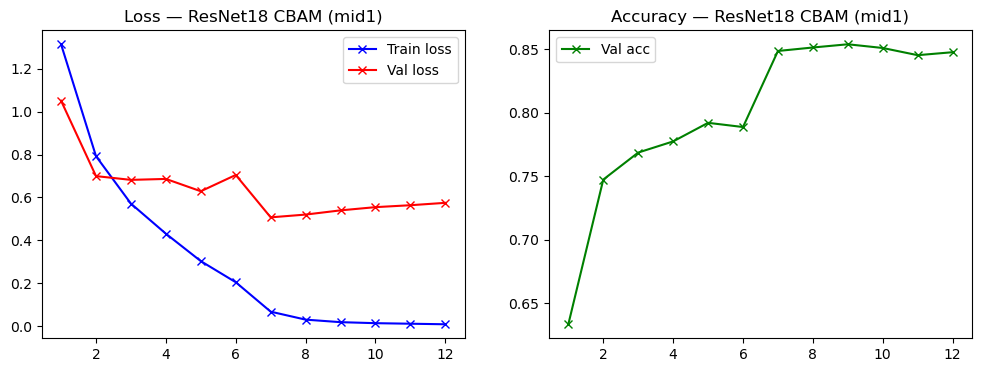

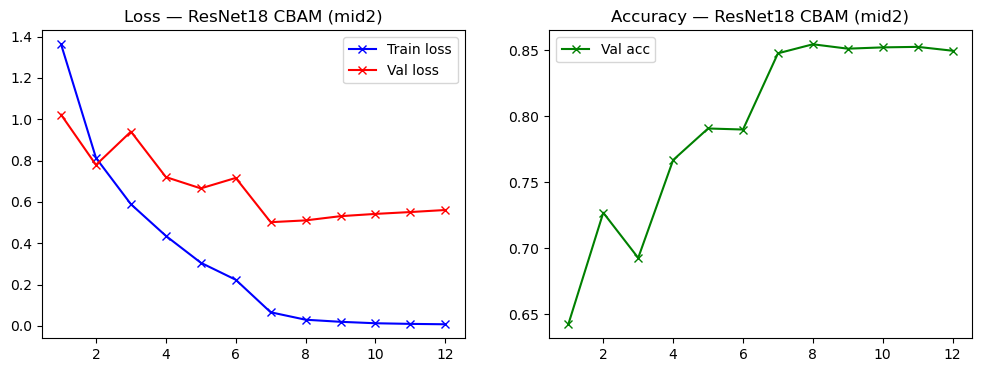

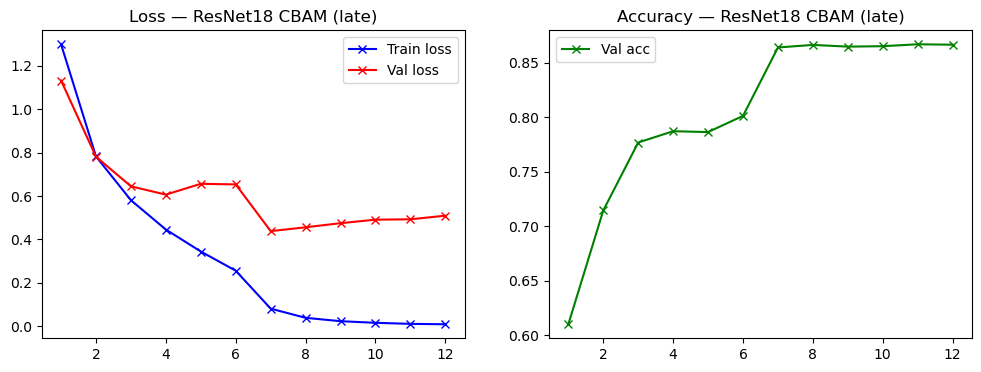

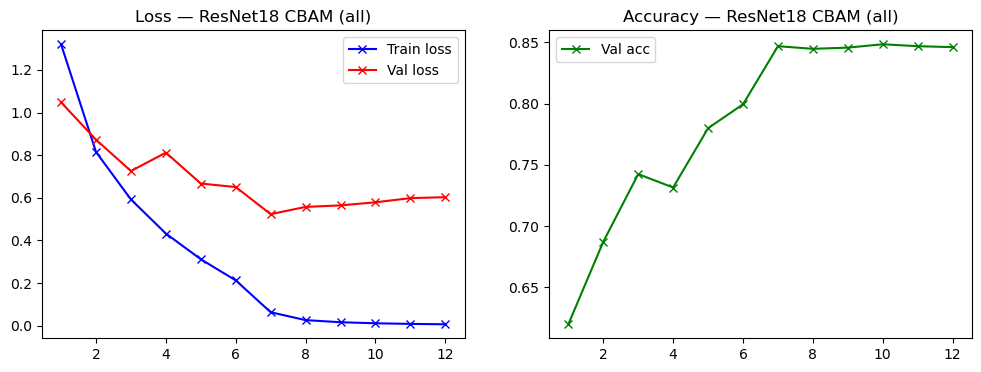

In [17]:
for r in results:
    title = f"{r['model']} {r['attention']} ({r['position']})"
    plot_training_curves(r["history"], title)